In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# cargamos la dataset
data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [3]:
# Importamos librerias

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from scipy import stats


In [4]:
# Visualizamos
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
 # 1460 registros y 81 variables, muchas son...
# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
data.shape

(1460, 81)

In [6]:
# Evaluamos misssing values,hay 19 variables con missing data, algunas con % insoportables.
pd.DataFrame(data.isnull().sum()/len(data)).rename(columns = {0: '% missing values'}).sort_values(by=['% missing values'], ascending=False).head(20)

,% missing values
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageCond,0.055479
GarageType,0.055479
GarageFinish,0.055479


In [7]:
# Eliminamos variables con % > 30% missing data, y la columna Id
data = data.drop(['PoolQC','Id','MiscFeature','Alley', 'Fence','FireplaceQu'], axis=1)

In [8]:
# Algunas numéricas son categóricas
cat = ['MSSubClass', 'OverallQual', 'OverallCond']
for c in cat:
    data[c] = data[c].astype('category')

In [9]:
# Todos los object pasan a ser "category"
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

In [10]:
corr = data.corr().stack().reset_index().sort_values(by=[0], ascending=False)
corr = corr[corr[0] != 1.0] # Eliminamos las coincidentes.
corr = corr[corr[0] > 0.80] # sólo selecciono corr > 75%
corr

,level_0,level_1,0
804,GarageArea,GarageCars,0.882475
771,GarageCars,GarageArea,0.882475
716,GarageYrBlt,YearBuilt,0.825667
89,YearBuilt,GarageYrBlt,0.825667
427,GrLivArea,TotRmsAbvGrd,0.825489
658,TotRmsAbvGrd,GrLivArea,0.825489
314,1stFlrSF,TotalBsmtSF,0.819530
281,TotalBsmtSF,1stFlrSF,0.819530


In [11]:
# Por la alta correlación, eliminamos estas 4 columnas
data = data.drop(['GarageCars','GarageYrBlt','TotRmsAbvGrd','TotalBsmtSF'], axis=1)

Index(['YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea', 'FullBath',
       'GarageArea', 'SalePrice'],
      dtype='object')

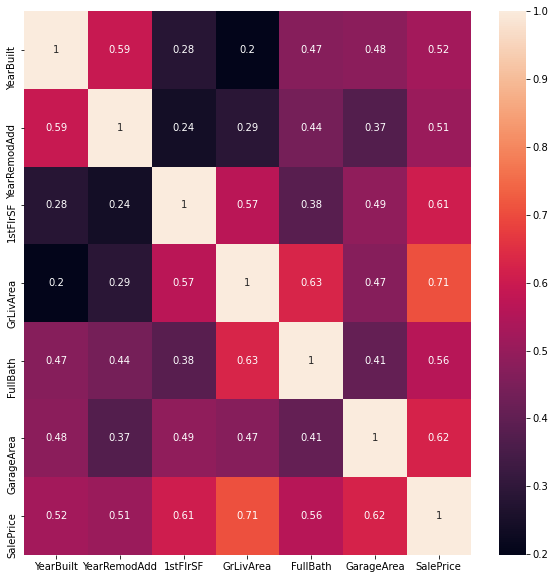

In [12]:
# DAtos correlacionados numéricos positivos
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>0.5]
plt.figure(figsize=(10,10))
sns.heatmap(data[top_corr_features].corr(),annot = True);
top_corr_features

In [13]:
# Imputar missing values

colmissing = pd.DataFrame(data.isnull().sum()/len(data)).rename(columns = {0: '% missing values'}).sort_values(by=['% missing values'], ascending=False).head(20)
colmissing = colmissing[colmissing['% missing values'] > 0]
# imputamos la moda si son categoricas y media si son numéricos



In [14]:
# imputamos según moda o media si son categóricos o no.
for i in range(len(colmissing)):
    
    if data[colmissing.index[i]].dtype.name is 'category':
        data[colmissing.index[i]] = data[colmissing.index[i]].fillna(data[colmissing.index[i]].mode()[0])
    else:
        data[colmissing.index[i]] = data[colmissing.index[i]].fillna(data[colmissing.index[i]].mean())

In [15]:
pd.DataFrame(data.isnull().sum()/len(data))

,0
MSSubClass,0.0
MSZoning,0.0
LotFrontage,0.0
LotArea,0.0
Street,0.0
...,...
MoSold,0.0
YrSold,0.0
SaleType,0.0
SaleCondition,0.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180921.20 and sigma = 79415.29



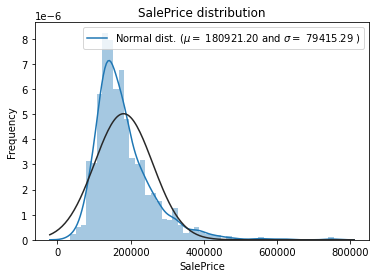

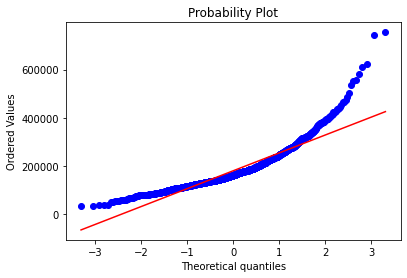

Skewness: 1.882876
Kurtosis: 6.536282


In [16]:
# El valor del precio sigue una distribución normal?

 #histogram
sns.distplot(data['SalePrice'] , fit=norm)


# variables de la normal
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Dibujo
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())


 mu = 12.02 and sigma = 0.40



/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


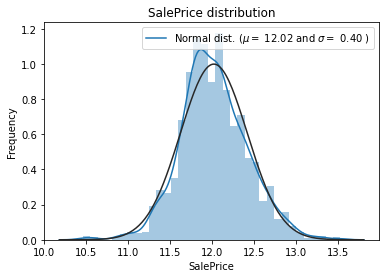

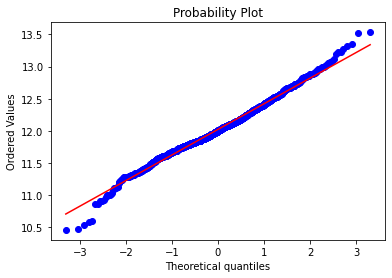

In [17]:
# Vamos a convertir los datos para que sean normales, mediante datos logarítmicos
# https://www.kaggle.com/usharanivankara/house-prices-prediction-with-lasso-and-ridge

data["SalePrice"] = np.log1p(data["SalePrice"])

#Check the new distribution 
sns.distplot(data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show()

In [18]:
data['SalePrice'] # Ha cambiado el valor, a tener en cuenta!!

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [19]:
pip install pycaret[full]

Note: you may need to restart the kernel to use updated packages.


In [20]:
from pycaret.regression import *
rg = setup(data = data, target = 'SalePrice') # Seleccionamos la dataset y la variable dependiente.

,Description,Value
0,session_id,2714
1,Target,SalePrice
2,Original Data,"(1460, 71)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,54
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 367)"


In [21]:
# Comparación de modelos, por defecto la comparación es por "R2"
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0862,0.0169,0.1284,0.8884,0.0099,0.0072,5.1610
br,Bayesian Ridge,0.0850,0.0176,0.1298,0.8821,0.0101,0.0071,0.1110
ridge,Ridge Regression,0.0888,0.0185,0.1337,0.8758,0.0104,0.0075,0.0300
omp,Orthogonal Matching Pursuit,0.0918,0.0186,0.1331,0.8738,0.0103,0.0077,0.0190
gbr,Gradient Boosting Regressor,0.0946,0.0193,0.1374,0.8704,0.0106,0.0079,0.3700
lightgbm,Light Gradient Boosting Machine,0.0976,0.0209,0.1434,0.8621,0.0111,0.0082,0.1930
xgboost,Extreme Gradient Boosting,0.1008,0.0229,0.1495,0.8487,0.0116,0.0084,23.7560
rf,Random Forest Regressor,0.1020,0.0233,0.1517,0.8469,0.0118,0.0086,1.1530
lr,Linear Regression,0.1049,0.0275,0.1634,0.8164,0.0128,0.0088,0.4110
et,Extra Trees Regressor,0.1153,0.0293,0.1699,0.8117,0.0132,0.0097,1.2120


In [23]:
# Trabajamos con CatBoost

import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [28]:
X = data.drop(['SalePrice'], axis = 1)
y = data['SalePrice']

In [44]:
cat = []
for col in X.columns:
    if X[col].dtype.name is 'category':
        cat.append(col)
    

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5) # Separamos train y test
train_dataset = cb.Pool(X_train, y_train, cat_features = cat) 
test_dataset = cb.Pool(X_test, y_test,  cat_features = cat)

In [50]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [51]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 11.6585999	test: 11.7088131	best: 11.7088131 (0)	total: 4.95ms	remaining: 490ms
1:	learn: 11.3094486	test: 11.3597219	best: 11.3597219 (1)	total: 7.38ms	remaining: 362ms
2:	learn: 10.9706900	test: 11.0205161	best: 11.0205161 (2)	total: 10.3ms	remaining: 335ms
3:	learn: 10.6421269	test: 10.6915474	best: 10.6915474 (3)	total: 12.5ms	remaining: 301ms
4:	learn: 10.3235312	test: 10.3730335	best: 10.3730335 (4)	total: 14.7ms	remaining: 279ms
5:	learn: 10.0144484	test: 10.0639052	best: 10.0639052 (5)	total: 16.8ms	remaining: 263ms
6:	learn: 9.7145464	test: 9.7637636	best: 9.7637636 (6)	total: 19ms	remaining: 253ms
7:	learn: 9.4237383	test: 9.4724645	best: 9.4724645 (7)	total: 21.1ms	remaining: 243ms
8:	learn: 9.1416876	test: 9.1902193	best: 9.1902193 (8)	total: 24.5ms	remaining: 248ms
9:	learn: 8.8681008	test: 8.9164052	best: 8.9164052 (9)	total: 27ms	remaining: 243ms
10:	learn: 8.6027562	test: 8.6509954	best: 8.6509954 (10)	total: 30.3ms	remaining: 245ms
11:	learn: 8.3453417	test: 

{'params': {'depth': 4,
  'iterations': 150,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [52]:
# Comparamos r2 train y test para evaluar overfitting, que lo hay.
# Pero debemos considerar nulo trabajo de análisis y feature engineering

pred = model.predict(X_test)
pred_train = model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2_test = r2_score(y_test, pred)
r2_train = r2_score(y_train, pred_train)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2_test: {:.2f}'.format(r2_test))
print('R2_train: {:.2f}'.format(r2_train))

Testing performance
RMSE: 0.12
R2_test: 0.91
R2_train: 0.94


In [53]:
# Subo la solución
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')


In [57]:
test = test[X.columns]

In [77]:
test.isnull().sum()

MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 70, dtype: int64

In [72]:
cat = []
for col in data.columns:
    if data[col].dtype.name is 'category':
        cat.append(col)
    

In [74]:
for col in cat:
    test[col] = test[col].astype('category')

In [84]:
pd.DataFrame(test.isnull().sum())

,0
MSSubClass,0
MSZoning,4
LotFrontage,0
LotArea,0
Street,0
...,...
MiscVal,0
MoSold,0
YrSold,0
SaleType,1


In [117]:
colmissing[colmissingT[0]>0]

,% missing values


In [110]:
# Imputar missing values

colmissingT = pd.DataFrame(test.isnull().sum()/len(test)).rename(columns = {0: '% missing values'}).sort_values(by=['% missing values'], ascending=False).head(20)
colmissingT = colmissing[colmissing['% missing values'] > 0]
# imputamos la moda si son categoricas y media si son numéricos

In [113]:
colmissingT = pd.DataFrame(test.isnull().sum()/len(test))

In [114]:
# imputamos según moda o media si son categóricos o no.
for i in range(len(colmissingT)):
    
    if test[colmissingT.index[i]].dtype.name is 'category':
        test[colmissingT.index[i]] = test[colmissingT.index[i]].fillna(test[colmissingT.index[i]].mode()[0])
    else:
        test[colmissingT.index[i]] = test[colmissingT.index[i]].fillna(test[colmissingT.index[i]].mean())

In [118]:
y_test = model.predict(test)
predictions = np.expm1(y_test) # hay que canviar escala

In [121]:
test2 = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [126]:
output = pd.DataFrame({'Id':test2['Id'], 'SalePrice': predictions})

In [127]:
output.to_csv('my_submission.csv', index=False)